In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/ai-lab-4")

In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [4]:
import nltk
nltk.download('conll2000')
nltk.download('universal_tagset')

from nltk.corpus import conll2000

[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [32]:
data= conll2000.chunked_sents()
from nltk.chunk.util import tree2conlltags

X = []
Y = []
for lines in data:
  X_sentence = []
  Y_sentence = []
  wtc=tree2conlltags(lines)
  for entity in wtc:
    X_sentence.append(entity[0])  # entity[0] contains the word
    Y_sentence.append(entity[2])  # entity[2] contains corresponding tag of POS tag
        
  X.append(X_sentence)
  Y.append(Y_sentence)


In [6]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [7]:
print("This gives dimensions of corpus:")
print("Number of sentences:", len(X))
print("Number of words:", num_words)
print("Number of tags:", num_tags)

This gives dimensions of corpus:
Number of sentences: 10948
Number of words: 19460
Number of tags: 7


In [8]:
"""
This encodes each each word with a unique numerical token.
"""
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [9]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [10]:
# make sure that each sequence of input and output is same length
# because it is a many-to-many problem so we need to ensure that input and output
# have same length in compleate corpus.

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [11]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 78


Visualize the lengths of all the senteces
This gives an idea about padding.


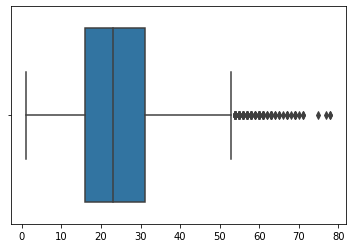

In [12]:
print("Visualize the lengths of all the senteces")
print("This gives an idea about padding.")
sns.boxplot(lengths)
plt.show()

In [13]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [14]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

In [15]:
# Commented below line so that we do not dowload same data again and again unnecesarily.
# !wget -q http://nlp.stanford.edu/data/glove.6B.zip

# Extract once and then comment below line to avoid same heavy step again again by mistake.
# !unzip "./glove.6B.zip" -d "glove"

Archive:  ./glove.6B.zip
replace glove/glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove/glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [16]:
# Converting glove vectors into word2vec format so that it can be used for training.

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = './glove/glove.6B.100d.txt'
word2vec_glove_file = "glove.6B.100d.word2vec.txt"
glove2word2vec(glove_file, word2vec_glove_file)

(400000, 100)

In [17]:
embeddings = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [18]:
# Ensure that model loaded is working as expected.
embeddings.wv.most_similar(positive = ["king", "woman"], negative = ["man"])

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.6311717629432678),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [19]:

EMBEDDING_SIZE  = 100  # each word in model is represented using a 100 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from embeddings model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = embeddings[word]
    except KeyError:
        pass

In [20]:
print("Embeddings shape: {}".format(embedding_weights.shape))
embedding_weights[word_tokenizer.word_index['king']]

Embeddings shape: (19461, 100)


array([-0.32306999, -0.87616003,  0.21977   ,  0.25268   ,  0.22976001,
        0.73879999, -0.37954   , -0.35306999, -0.84368998, -1.11129999,
       -0.30265999,  0.33177999, -0.25113001,  0.30447999, -0.077491  ,
       -0.89815003,  0.092496  , -1.14069998, -0.58323997,  0.66869003,
       -0.23122001, -0.95854998,  0.28262001, -0.078848  ,  0.75314999,
        0.26583999,  0.34220001, -0.33949   ,  0.95608002,  0.065641  ,
        0.45747   ,  0.39835   ,  0.57964998,  0.39267001, -0.21851   ,
        0.58794999, -0.55998999,  0.63367999, -0.043983  , -0.68730998,
       -0.37841001,  0.38025999,  0.61641002, -0.88269001, -0.12346   ,
       -0.37928   , -0.38317999,  0.23868001,  0.66850001, -0.43320999,
       -0.11065   ,  0.081723  ,  1.15690005,  0.78957999, -0.21223   ,
       -2.3211    , -0.67806   ,  0.44560999,  0.65706998,  0.1045    ,
        0.46217   ,  0.19912   ,  0.25802001,  0.057194  ,  0.53443003,
       -0.43133   , -0.34311   ,  0.59789002, -0.58416998,  0.06

In [21]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)


# print Y of the first output sequqnce
print(Y.shape)

(10948, 100, 8)


In [22]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [23]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [24]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (7909, 100)
Shape of output sequences: (7909, 100, 8)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1396, 100)
Shape of output sequences: (1396, 100, 8)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (1643, 100)
Shape of output sequences: (1643, 100, 8)


In [25]:
# total number of tags
NUM_CLASSES = Y.shape[2]

### Below is  implementation of Simple RNN model that uses word embeddings
### we trained in above cells.

In [26]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [27]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [28]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1946100   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 64)           10560     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 8)            520       
Total params: 1,957,180
Trainable params: 1,957,180
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Train the model
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
62/62 [==============================] - 7s 94ms/step - loss: 1.0088 - acc: 0.8343 - val_loss: 0.2864 - val_acc: 0.9208
Epoch 2/10
62/62 [==============================] - 5s 84ms/step - loss: 0.2427 - acc: 0.9355 - val_loss: 0.1630 - val_acc: 0.9594
Epoch 3/10
62/62 [==============================] - 5s 85ms/step - loss: 0.1413 - acc: 0.9642 - val_loss: 0.1127 - val_acc: 0.9704
Epoch 4/10
62/62 [==============================] - 5s 84ms/step - loss: 0.0970 - acc: 0.9745 - val_loss: 0.0899 - val_acc: 0.9747
Epoch 5/10
62/62 [==============================] - 5s 83ms/step - loss: 0.0755 - acc: 0.9790 - val_loss: 0.0773 - val_acc: 0.9770
Epoch 6/10
62/62 [==============================] - 5s 85ms/step - loss: 0.0621 - acc: 0.9820 - val_loss: 0.0700 - val_acc: 0.9786
Epoch 7/10
62/62 [==============================] - 5s 83ms/step - loss: 0.0545 - acc: 0.9839 - val_loss: 0.0656 - val_acc: 0.9797
Epoch 8/10
62/62 [==============================] - 5s 85ms/step - loss: 0.0490 - a

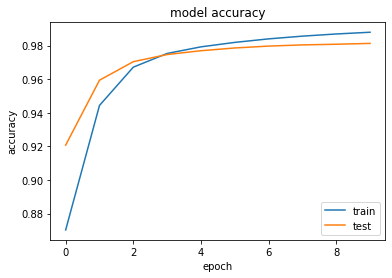

In [30]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [35]:
rnn_model.save("chunking_rnn_model")

INFO:tensorflow:Assets written to: chunking_rnn_model/assets


In [36]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

52/52 [==============================] - 0s 9ms/step - loss: 0.0557 - acc: 0.9821
Loss: 0.05574947968125343,
Accuracy: 0.9820876717567444
